In [2]:
import pandas as pd
import numpy as np
import umap
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import vaex
vaex.multithreading.thread_count_default = 8
import vaex.ml
import pickle

In [3]:
pristine = pd.read_csv('/arc/home/aydanmckay/leftjoinpristinesspplamostlrsmilliquas.csv',
                   usecols=["CaHK_0_p","e_CaHK_p","pmra_1_p","pmra_error_1_p","pmdec_1_p","pmdec_error_1_p","g_chp_psf_p","r_chp_psf_p",
                            "i_chp_psf_p","z_chp_psf_p","y_chp_psf_p","MAG_AUTO_p",
                            "phot_g_mean_mag_1_p","phot_bp_mean_mag_1_p","phot_rp_mean_mag_1_p","AFE_s","FEH_ADOP_s","TEFF_ADOP_s","LOGG_ADOP_s",
                            "SNR_s","FEH_ADOP_UNC_s","RV_ADOP_UNC_s"])

In [29]:
pristine = pristine.loc[(pristine["g_chp_psf_p"] < 1e19) & (pristine["r_chp_psf_p"] < 1e19) & (pristine["i_chp_psf_p"] < 1e19) & \
                        (pristine["z_chp_psf_p"] < 1e19) & (pristine["y_chp_psf_p"] < 1e19) & (pristine["MAG_AUTO_p"] < 95) & \
                        (np.isnan(pristine["phot_g_mean_mag_1_p"]) == False) & (np.isnan(pristine["phot_bp_mean_mag_1_p"]) == False) & \
                        (np.isnan(pristine["pmra_1_p"]) == False) & (np.isnan(pristine["pmdec_1_p"]) == False) & \
                        (np.isnan(pristine["pmra_error_1_p"]) == False) & (np.isnan(pristine["pmdec_error_1_p"]) == False) & \
                        (np.isnan(pristine["phot_rp_mean_mag_1_p"]) == False) & (pristine['SNR_s'] > 25.) & (np.isnan(pristine['LOGG_ADOP_s']) == False) & \
                        (pristine['RV_ADOP_UNC_s'] < 10.) & (pristine['TEFF_ADOP_s'] < 7000.) & (pristine['FEH_ADOP_UNC_s'] < 0.2) & \
                        (pristine["e_CaHK_p"] < 0.05) & (pristine['FEH_ADOP_s'] > -5)]

In [30]:
df = vaex.from_pandas(pd.DataFrame({'PMRA': pristine['pmra_1_p'],
                   'PMDec': pristine['pmdec_1_p'],
                   'PMRAerr': pristine['pmra_error_1_p'],
                   'PMDecerr': pristine['pmdec_error_1_p'],
                   'G_gaia': pristine['CaHK_0_p']-pristine['phot_g_mean_mag_1_p'],
                   'B_gaia': pristine['CaHK_0_p']-pristine['phot_bp_mean_mag_1_p'],
                   'R_gaia': pristine['CaHK_0_p']-pristine['phot_rp_mean_mag_1_p'],
                   'G_pan': pristine['CaHK_0_p']-pristine['g_chp_psf_p'],
                   'R_pan': pristine['CaHK_0_p']-pristine['r_chp_psf_p'],
                   'I_pan': pristine['CaHK_0_p']-pristine['i_chp_psf_p'],
                   'Z_pan': pristine['CaHK_0_p']-pristine['z_chp_psf_p'],
                   'Y_pan': pristine['CaHK_0_p']-pristine['y_chp_psf_p'],
                   'AUTO_cfis': pristine['CaHK_0_p']-pristine['MAG_AUTO_p']}))

df2 = pd.DataFrame({'FeH': pristine['FEH_ADOP_s']})

In [31]:
# print(df.shape)
data = df.dropna()
# print(data.shape)
# print(df2.shape)
data2 = df2.dropna()
# print(data2.shape)

In [32]:
reducer = umap.UMAP(random_state=42,verbose=True)

In [33]:
scaled_star_data = StandardScaler().fit_transform(data)

In [34]:
reducer.fit(scaled_star_data)

UMAP(dens_frac=0.0, dens_lambda=0.0, random_state=42, verbose=True)
Construct fuzzy simplicial set
Wed Feb  2 19:16:03 2022 Finding Nearest Neighbors
Wed Feb  2 19:16:03 2022 Building RP forest with 12 trees
Wed Feb  2 19:16:03 2022 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Wed Feb  2 19:16:04 2022 Finished Nearest Neighbor Search
Wed Feb  2 19:16:04 2022 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Wed Feb  2 19:16:20 2022 Finished embedding


UMAP(dens_frac=0.0, dens_lambda=0.0, random_state=42, verbose=True)

In [35]:
embedding = reducer.transform(scaled_star_data)

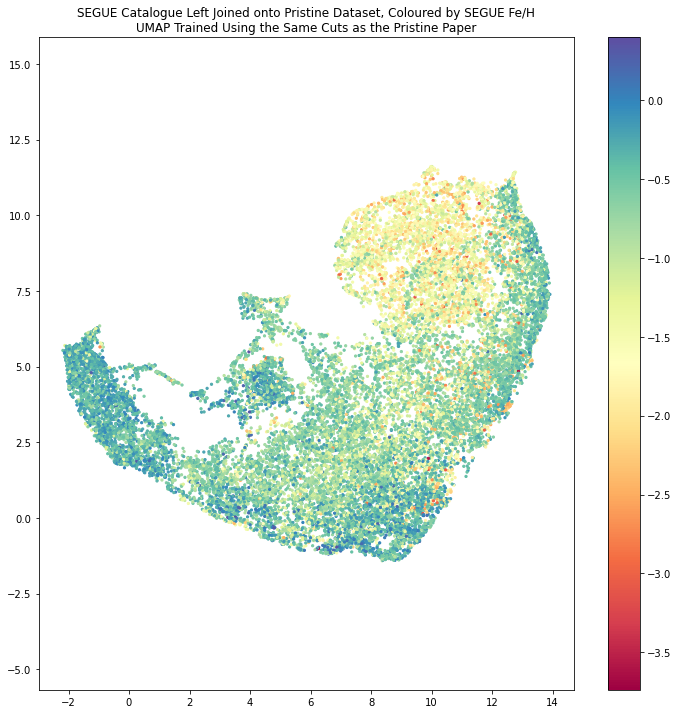

In [36]:
mask_feh = data2['FeH'] > -9
plt.figure(figsize=(12,12))
plt.scatter(embedding[:, 0][mask_feh], embedding[:, 1][mask_feh],c=data2['FeH'][mask_feh], cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar()
plt.title("SEGUE Catalogue Left Joined onto Pristine Dataset, Coloured by SEGUE Fe/H\nUMAP Trained Using the Same Cuts as the Pristine Paper");
# plt.savefig('/arc/home/aydanmckay/allcutsmadeunsoop.png')

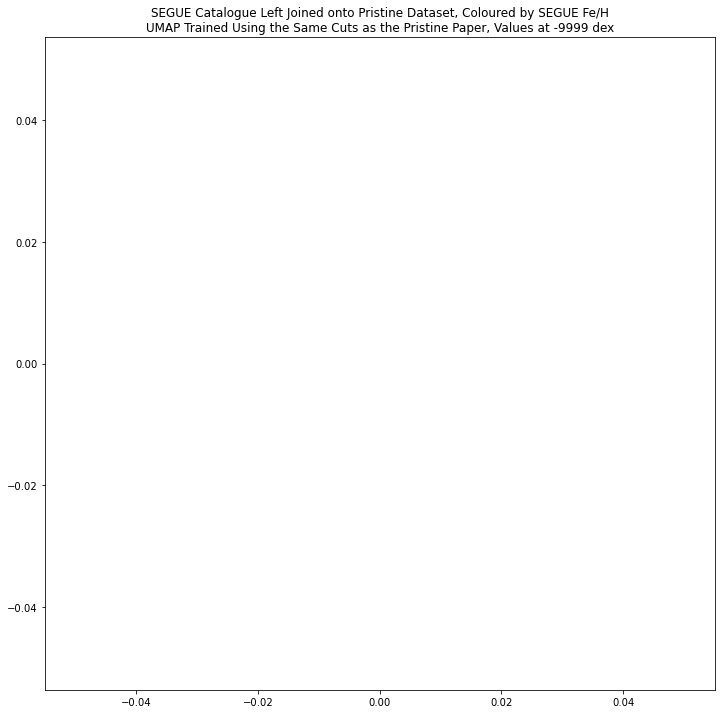

In [37]:
mask_feh = data2['FeH'] < -9
plt.figure(figsize=(12,12))
plt.scatter(embedding[:, 0][mask_feh], embedding[:, 1][mask_feh],c=data2['FeH'][mask_feh], s=5)
plt.gca().set_aspect('equal', 'datalim')
# plt.colorbar()
plt.title("SEGUE Catalogue Left Joined onto Pristine Dataset, Coloured by SEGUE Fe/H\nUMAP Trained Using the Same Cuts as the Pristine Paper, Values at -9999 dex");
# plt.savefig('/arc/home/aydanmckay/allcutsmadeunsoop9999.png')

In [41]:
data2['FeH']

<bound method IndexOpsMixin.value_counts of 14        -1.453091
17        -1.081400
89        -0.001956
92        -0.597302
95        -0.567935
             ...   
4113407   -0.983010
4113463   -0.476660
4114075   -0.637742
4114206   -1.814355
4114271   -0.124109
Name: FeH, Length: 22417, dtype: float64>